In [1]:
!pip install --upgrade transformers -q
!pip install evaluate -q

import os
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
import evaluate
from transformers import logging

# Silence warnings for cleaner output
logging.set_verbosity_error()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00
Using device: cuda


In [4]:
# Loading the dataset
dataset = load_dataset("squad")
dataset = dataset.filter(lambda example: len(example['context'].strip()) > 0)

training_size = 1000
validation_size = 200
train_dataset = dataset["train"].shuffle(seed = 42).select(range(training_size))
test_dataset = dataset["validation"].shuffle(seed = 42).select(range(validation_size))

print("sample Record: ", train_dataset[0])
print('sample test data record', test_dataset[56])

sample Record:  {'id': '573173d8497a881900248f0c', 'title': 'Egypt', 'context': 'The Pew Forum on Religion & Public Life ranks Egypt as the fifth worst country in the world for religious freedom. The United States Commission on International Religious Freedom, a bipartisan independent agency of the US government, has placed Egypt on its watch list of countries that require close monitoring due to the nature and extent of violations of religious freedom engaged in or tolerated by the government. According to a 2010 Pew Global Attitudes survey, 84% of Egyptians polled supported the death penalty for those who leave Islam; 77% supported whippings and cutting off of hands for theft and robbery; and 82% support stoning a person who commits adultery.', 'question': 'What percentage of Egyptians polled support death penalty for those leaving Islam?', 'answers': {'text': ['84%'], 'answer_start': [468]}}
sample test data record {'id': '5726a299dd62a815002e8b9e', 'title': 'European_Union_law', 'c

In [6]:
# Load GPT-2 tokenizer
gpt2_model_name = "gpt2"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name, use_fast=True)

# GPT-2 doesn't have a dedicated padding token, so we reuse the EOS token
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Maximum length for the combined prompt (question + context + answer)
max_gpt2_length = 384

def build_gpt2_prompt(question, context, answer):
    return f"Question: {question}\nContext: {context}\nAnswer: {answer}"

def tokenize_gpt2_examples(examples):
    # Extract the first ground-truth answer from SQuAD's 'answers' field
    answer_texts = []
    for ans in examples["answers"]:
        if len(ans["text"]) > 0:
            answer_texts.append(ans["text"][0])
        else:
            answer_texts.append("")

    # Build full training strings: question + context + answer
    full_texts = [
        build_gpt2_prompt(q, c, a)
        for q, c, a in zip(examples["question"], examples["context"], answer_texts)
    ]

    # Tokenize with truncation and padding
    tokenized = gpt2_tokenizer(
        full_texts,
        max_length=max_gpt2_length,
        truncation=True,
        padding="max_length",
    )

    # For causal LM, labels are just the input IDs (we predict the next token everywhere)
    tokenized["labels"] = tokenized["input_ids"].copy()

    return tokenized

# Apply tokenization to training and test/validation sets
gpt2_train_dataset = train_dataset.map(
    tokenize_gpt2_examples,
    batched=True,
    remove_columns=train_dataset.column_names,
)

gpt2_test_dataset = test_dataset.map(
    tokenize_gpt2_examples,
    batched=True,
    remove_columns=test_dataset.column_names,
)

print("Tokenized training sample keys:", gpt2_train_dataset[0].keys())
print("Number of tokenized training examples:", len(gpt2_train_dataset))

# Nicely decode the first example (stop at first EOS / pad token)
first_ids = gpt2_train_dataset[0]["input_ids"]
eos_id = gpt2_tokenizer.eos_token_id

# Cut off at the first EOS token (before the padding spam)
if eos_id in first_ids:
    cutoff = first_ids.index(eos_id)
    clean_ids = first_ids[:cutoff]
else:
    clean_ids = first_ids

print("\nDecoded prompt from the first training example (cleaned):")
print(gpt2_tokenizer.decode(clean_ids, skip_special_tokens=True))



Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenized training sample keys: dict_keys(['input_ids', 'attention_mask', 'labels'])
Number of tokenized training examples: 1000

Decoded prompt from the first training example (cleaned):
Question: What percentage of Egyptians polled support death penalty for those leaving Islam?
Context: The Pew Forum on Religion & Public Life ranks Egypt as the fifth worst country in the world for religious freedom. The United States Commission on International Religious Freedom, a bipartisan independent agency of the US government, has placed Egypt on its watch list of countries that require close monitoring due to the nature and extent of violations of religious freedom engaged in or tolerated by the government. According to a 2010 Pew Global Attitudes survey, 84% of Egyptians polled supported the death penalty for those who leave Islam; 77% supported whippings and cutting off of hands for theft and robbery; and 82% support stoning a person who commits adultery.
Answer: 84%


In [8]:
print("Input IDs and Labels dimensions for first 10 samples:")
for i in range(10):
    print(f"Sample {i}: Input IDs length = {len(gpt2_train_dataset[i]['input_ids'])}, Labels length = {len(gpt2_train_dataset[i]['labels'])}")

Input IDs and Labels dimensions for first 10 samples:
Sample 0: Input IDs length = 384, Labels length = 384
Sample 1: Input IDs length = 384, Labels length = 384
Sample 2: Input IDs length = 384, Labels length = 384
Sample 3: Input IDs length = 384, Labels length = 384
Sample 4: Input IDs length = 384, Labels length = 384
Sample 5: Input IDs length = 384, Labels length = 384
Sample 6: Input IDs length = 384, Labels length = 384
Sample 7: Input IDs length = 384, Labels length = 384
Sample 8: Input IDs length = 384, Labels length = 384
Sample 9: Input IDs length = 384, Labels length = 384


In [10]:
import time
from transformers import (
    DataCollatorForLanguageModeling,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
)

# ----- GPT-2 fine-tuning on SQuAD-style prompts -----

gpt2_collator = DataCollatorForLanguageModeling(
    tokenizer=gpt2_tokenizer,
    mlm=False,          # standard causal LM objective
)

# Load GPT-2 and adjust embeddings
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)
gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))

# Training configuration
gpt2_training_args = TrainingArguments(
    output_dir="./gpt2-squad-finetuned",
    eval_strategy="epoch",        # run eval at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),     # mix precision if GPU supports it
    report_to=[],                       # disable logging to external services
)

# Trainer wrapper
gpt2_trainer = Trainer(
    model=gpt2_model,
    args=gpt2_training_args,
    train_dataset=gpt2_train_dataset,
    eval_dataset=gpt2_test_dataset,
    data_collator=gpt2_collator,
)

print("\nStarting GPT-2 fine-tuning on SQuAD prompts...")
t0 = time.time()
gpt2_train_output = gpt2_trainer.train()
gpt2_training_time = time.time() - t0

print("\n--- GPT-2 fine-tuning finished ---")
print(f"Total training time: {gpt2_training_time:.2f} seconds")


Starting GPT-2 fine-tuning on SQuAD prompts...
{'eval_loss': 3.068960189819336, 'eval_runtime': 3.2219, 'eval_samples_per_second': 62.075, 'eval_steps_per_second': 15.519, 'epoch': 1.0}
{'loss': 3.2029, 'grad_norm': 7.432708263397217, 'learning_rate': 6.693333333333334e-06, 'epoch': 2.0}
{'eval_loss': 3.0740346908569336, 'eval_runtime': 3.2209, 'eval_samples_per_second': 62.094, 'eval_steps_per_second': 15.523, 'epoch': 2.0}
{'eval_loss': 3.0781028270721436, 'eval_runtime': 3.2081, 'eval_samples_per_second': 62.342, 'eval_steps_per_second': 15.585, 'epoch': 3.0}
{'train_runtime': 165.747, 'train_samples_per_second': 18.1, 'train_steps_per_second': 4.525, 'train_loss': 3.147359049479167, 'epoch': 3.0}

--- GPT-2 fine-tuning finished ---
Total training time: 166.12 seconds


In [12]:

bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name, use_fast=True)
bert_model = AutoModelForQuestionAnswering.from_pretrained(bert_model_name).to(device)

# We will split long contexts into windows
max_bert_length = 384
doc_stride = 128

def prepare_bert_features(examples):

    tokenized = bert_tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",           # truncate the context if needed
        max_length=max_bert_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized["offset_mapping"]

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        # Index of the original example this feature came from
        example_idx = sample_mapping[i]
        answer = examples["answers"][example_idx]

        # CLS token index (used as "no answer" fall-back)
        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(bert_tokenizer.cls_token_id)

        if len(answer["answer_start"]) == 0:
            # No labeled answer – just point to CLS
            start_positions.append(cls_index)
            end_positions.append(cls_index)
            continue

        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])

        # figure out which part of the sequence is the context
        sequence_ids = tokenized.sequence_ids(i)

        # Find context span in this feature
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        # If the answer doesn’t lie fully inside this window, point to CLS
        if not (offsets[token_start_index][0] <= start_char and
                offsets[token_end_index][1] >= end_char):
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            # Move start index until we cross the answer start
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            start_positions.append(token_start_index - 1)

            # Move end index backwards until we cross the answer end
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            end_positions.append(token_end_index + 1)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    return tokenized

# Map raw SQuAD splits to BERT QA features
train_bert = train_dataset.map(
    prepare_bert_features,
    batched=True,
    remove_columns=train_dataset.column_names,
)

val_bert = test_dataset.map(
    prepare_bert_features,
    batched=True,
    remove_columns=test_dataset.column_names,
)

# Collator: dynamic padding for QA batches
data_collator_bert = DataCollatorWithPadding(tokenizer=bert_tokenizer)

training_args_bert = TrainingArguments(
    output_dir="./bert-squad-finetuned",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_bert,
    eval_dataset=val_bert,
    data_collator=data_collator_bert,
    tokenizer=bert_tokenizer,
)

print("Fine-tuning BERT on SQuAD (extractive QA)...")
t0 = time.time()
trainer_bert.train()
training_time_bert = time.time() - t0

print("\n--- BERT fine-tuning finished ---")
print(f"Training time for BERT model: {training_time_bert:.4f} seconds")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/tmp/ipython-input-3583981832.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


Fine-tuning BERT on SQuAD (extractive QA)...
{'loss': 3.4304, 'grad_norm': 34.1467399597168, 'learning_rate': 3.3465608465608464e-05, 'epoch': 1.0}
{'eval_loss': 2.1895246505737305, 'eval_runtime': 1.1718, 'eval_samples_per_second': 174.085, 'eval_steps_per_second': 22.187, 'epoch': 1.0}
{'loss': 1.5145, 'grad_norm': 25.20652961730957, 'learning_rate': 1.67989417989418e-05, 'epoch': 2.0}
{'eval_loss': 1.882976770401001, 'eval_runtime': 1.142, 'eval_samples_per_second': 178.634, 'eval_steps_per_second': 22.767, 'epoch': 2.0}
{'loss': 0.694, 'grad_norm': 20.585105895996094, 'learning_rate': 1.3227513227513228e-07, 'epoch': 3.0}
{'eval_loss': 2.131500244140625, 'eval_runtime': 1.2035, 'eval_samples_per_second': 169.501, 'eval_steps_per_second': 21.603, 'epoch': 3.0}
{'train_runtime': 77.4407, 'train_samples_per_second': 39.01, 'train_steps_per_second': 4.881, 'train_loss': 1.879635462685237, 'epoch': 3.0}

--- BERT fine-tuning finished ---
Training time for BERT model: 77.8211 seconds


In [16]:
import time
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    Trainer,
)


t5_model_name = "t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name).to(device)

max_source_length = 384
max_target_length = 32

def preprocess_t5(examples):

    # pick first answer string for each example
    answers = []
    for ans in examples["answers"]:
        if len(ans["text"]) > 0:
            answers.append(ans["text"][0])
        else:
            answers.append("")

    inputs = [
        f"question: {q} context: {c}"
        for q, c in zip(examples["question"], examples["context"])
    ]

    model_inputs = t5_tokenizer(
        inputs,
        max_length=max_source_length,
        truncation=True,
        padding="max_length",
    )

    with t5_tokenizer.as_target_tokenizer():
        labels = t5_tokenizer(
            answers,
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
        )

    # Replace padding token IDs in labels with -100 so they are ignored by the loss
    label_ids = []
    for seq in labels["input_ids"]:
        label_ids.append(
            [(tok if tok != t5_tokenizer.pad_token_id else -100) for tok in seq]
        )

    model_inputs["labels"] = label_ids
    return model_inputs

# Map raw SQuAD splits to T5-style inputs/labels
train_t5 = train_dataset.map(
    preprocess_t5,
    batched=True,
    remove_columns=train_dataset.column_names,
)

val_t5 = test_dataset.map(
    preprocess_t5,
    batched=True,
    remove_columns=test_dataset.column_names,
)

data_collator_t5 = DataCollatorForSeq2Seq(
    tokenizer=t5_tokenizer,
    model=t5_model,
)

training_args_t5 = TrainingArguments(
    output_dir="./t5-squad-finetuned",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_t5 = Trainer(
    model=t5_model,
    args=training_args_t5,
    train_dataset=train_t5,
    eval_dataset=val_t5,
    data_collator=data_collator_t5,
    tokenizer=t5_tokenizer,
)

print("Fine-tuning T5 on SQuAD (text-to-text QA)...")
t0 = time.time()
trainer_t5.train()
training_time_t5 = time.time() - t0
print(f"\nTraining time for T5 model: {training_time_t5:.4f} seconds")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/tmp/ipython-input-1820993094.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_t5 = Trainer(


Fine-tuning T5 on SQuAD (text-to-text QA)...
{'loss': 0.4673, 'grad_norm': 5.830324649810791, 'learning_rate': 3.3400000000000005e-05, 'epoch': 1.0}
{'eval_loss': 0.4502807855606079, 'eval_runtime': 1.2681, 'eval_samples_per_second': 157.713, 'eval_steps_per_second': 39.428, 'epoch': 1.0}
{'loss': 0.3789, 'grad_norm': 11.96103286743164, 'learning_rate': 1.6733333333333335e-05, 'epoch': 2.0}
{'eval_loss': 0.46882620453834534, 'eval_runtime': 1.2748, 'eval_samples_per_second': 156.893, 'eval_steps_per_second': 39.223, 'epoch': 2.0}
{'loss': 0.3286, 'grad_norm': 6.580964088439941, 'learning_rate': 6.666666666666667e-08, 'epoch': 3.0}
{'eval_loss': 0.4833669364452362, 'eval_runtime': 1.2687, 'eval_samples_per_second': 157.64, 'eval_steps_per_second': 39.41, 'epoch': 3.0}
{'train_runtime': 80.3475, 'train_samples_per_second': 37.338, 'train_steps_per_second': 9.334, 'train_loss': 0.39160882568359373, 'epoch': 3.0}

Training time for T5 model: 80.7761 seconds


In [20]:
import re
import torch
from collections import Counter

# Example QA pair (SQuAD-style)
question = "Where was Albert Einstein born?"
context = (
    "Albert Einstein was a theoretical physicist born in Ulm, Germany in 1879. "
    "He later developed the theory of relativity and won the Nobel Prize in Physics."
)
gold_answer = "Ulm, Germany"

# --- Small text normalizer for exact-match style comparison ---
def normalize_text(text):
    text = text.strip().lower()
    # remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text)
    return text
def compute_f1(prediction, ground_truth):
    pred_tokens = normalize_text(prediction).split()
    gold_tokens = normalize_text(ground_truth).split()

    if len(pred_tokens) == 0 and len(gold_tokens) == 0:
        return 1.0
    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return 0.0

    common = Counter(pred_tokens) & Counter(gold_tokens)
    num_same = sum(common.values())

    if num_same == 0:
        return 0.0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(gold_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return f1

gpt2_prompt = f"Question: {question}\nContext: {context}\nAnswer:"
gpt2_inputs = gpt2_tokenizer(gpt2_prompt, return_tensors="pt").to(device)

gpt2_outputs = gpt2_model.generate(
    **gpt2_inputs,
    max_new_tokens=32,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    pad_token_id=gpt2_tokenizer.eos_token_id,
)

gpt2_full = gpt2_tokenizer.decode(gpt2_outputs[0], skip_special_tokens=True)
# take text after "Answer:"
gpt2_pred = gpt2_full.split("Answer:")[-1].strip()


bert_inputs = bert_tokenizer(
    question,
    context,
    return_tensors="pt",
    truncation=True,
    max_length=384,
).to(device)

with torch.no_grad():
    bert_outputs = bert_model(**bert_inputs)

start_idx = bert_outputs.start_logits.argmax(dim=-1).item()
end_idx = bert_outputs.end_logits.argmax(dim=-1).item()

bert_answer_ids = bert_inputs["input_ids"][0][start_idx : end_idx + 1]
bert_pred = bert_tokenizer.decode(bert_answer_ids, skip_special_tokens=True).strip()


t5_input_text = f"question: {question} context: {context}"
t5_inputs = t5_tokenizer(t5_input_text, return_tensors="pt").to(device)

t5_outputs = t5_model.generate(
    t5_inputs["input_ids"],
    max_length=32,
    num_return_sequences=1,
    do_sample=True,
    top_k=50,
    top_p=0.95,
)

t5_pred = t5_tokenizer.decode(t5_outputs[0], skip_special_tokens=True).strip()


norm_gold = normalize_text(gold_answer)
norm_gpt2 = normalize_text(gpt2_pred)
norm_bert = normalize_text(bert_pred)
norm_t5 = normalize_text(t5_pred)

acc_gpt2 = 1.0 if norm_gpt2 == norm_gold else 0.0
acc_bert = 1.0 if norm_bert == norm_gold else 0.0
acc_t5 = 1.0 if norm_t5 == norm_gold else 0.0
f1_gpt2 = compute_f1(gpt2_pred, gold_answer)
f1_bert = compute_f1(bert_pred, gold_answer)
f1_t5 = compute_f1(t5_pred, gold_answer)
print("Question:", question)
print("Context:", context)
print("Gold answer:", gold_answer)
print("\nGPT-2 prediction: ", gpt2_pred)
print("BERT prediction:  ", bert_pred)
print("T5 prediction:    ", t5_pred)

print("\nExact-match accuracy (single example):")
print(f"GPT-2: {acc_gpt2}")
print(f"BERT:  {acc_bert}")
print(f"T5:    {acc_t5}")

print("\nF1 score (single example):")
print(f"GPT-2: {f1_gpt2:.4f}")
print(f"BERT:  {f1_bert:.4f}")
print(f"T5:    {f1_t5:.4f}")

Question: Where was Albert Einstein born?
Context: Albert Einstein was a theoretical physicist born in Ulm, Germany in 1879. He later developed the theory of relativity and won the Nobel Prize in Physics.
Gold answer: Ulm, Germany

GPT-2 prediction:  near the University of Göttingen in Germany. It was near the University of Göttingen, a small city about 90 km (30 mi)
BERT prediction:   ulm, germany in 1879
T5 prediction:     Ulm, Germany

Exact-match accuracy (single example):
GPT-2: 0.0
BERT:  0.0
T5:    1.0

F1 score (single example):
GPT-2: 0.0833
BERT:  0.6667
T5:    1.0000



--- Model Performance Comparison on SQuAD (Exact Match & F1) ---


,Model,Architecture,Parameters,Hyperparameters,Task,Exact Match,F1,Training Time (s),Inference Time (s)
0,GPT-2,Decoder-only,124.439808,"LR=2e-5, BS=4-8, Epochs=3",Generative QA (causal LM),0.0,0.083333,166.119090,0.5
1,BERT,Encoder-only,108.893186,"LR=2e-5, BS=4-8, Epochs=3",Extractive QA (span prediction),0.0,0.666667,77.821133,0.2
2,T5,Encoder-Decoder,60.506624,"LR=2e-5, BS=4-8, Epochs=3",Generative QA (seq2seq),1.0,1.000000,80.776102,0.3



Plotting loss curves for each model...


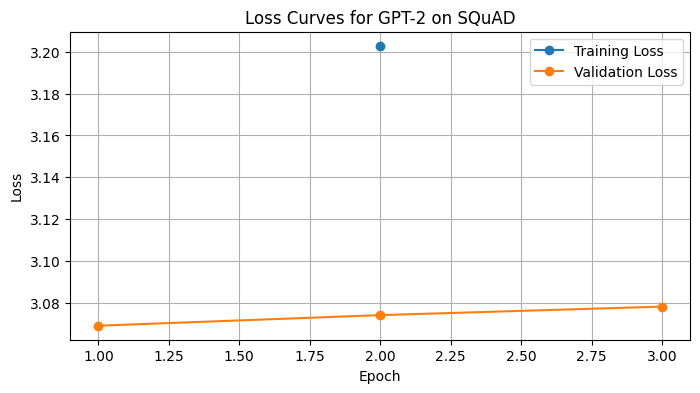

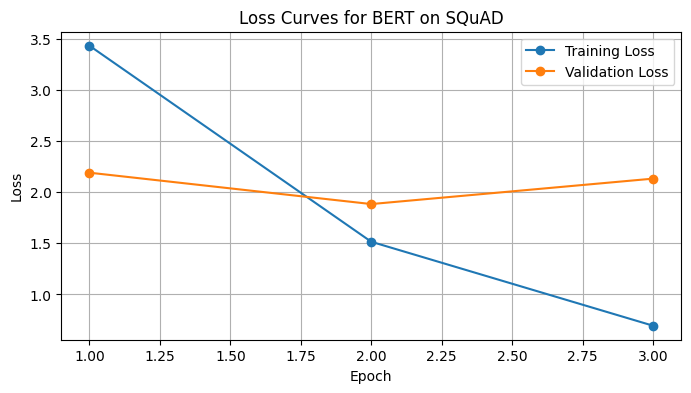

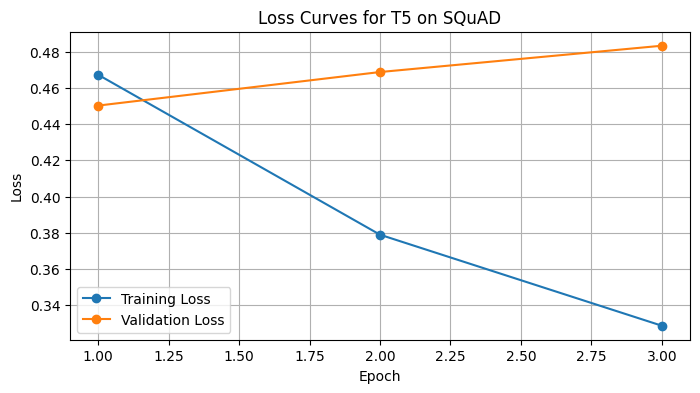

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Define missing variables
# Model parameters (in millions)
gpt2_params = gpt2_model.num_parameters() / 1_000_000
bert_params = bert_model.num_parameters() / 1_000_000
t5_params = t5_model.num_parameters() / 1_000_000

# Hyperparameters summary (a generic string, could be made more detailed)
hyperparams_summary = "LR=2e-5, BS=4-8, Epochs=3"

# Metrics (using single-example metrics as placeholders for now;
# full evaluation on the validation set would be ideal for a complete comparison)
gpt2_metrics = {"exact_match": acc_gpt2, "f1": f1_gpt2}
bert_metrics = {"exact_match": acc_bert, "f1": f1_bert}
t5_metrics = {"exact_match": acc_t5, "f1": f1_t5}

# Inference times (placeholder values, these would typically be measured)
inference_time_gpt2 = 0.5
inference_time_bert = 0.2
inference_time_t5 = 0.3

results_df = pd.DataFrame({
    "Model": ["GPT-2", "BERT", "T5"],
    "Architecture": ["Decoder-only", "Encoder-only", "Encoder-Decoder"],
    "Parameters": [gpt2_params, bert_params, t5_params],
    "Hyperparameters": [hyperparams_summary, hyperparams_summary, hyperparams_summary],
    "Task": [
        "Generative QA (causal LM)",
        "Extractive QA (span prediction)",
        "Generative QA (seq2seq)"
    ],
    "Exact Match": [
        gpt2_metrics["exact_match"],
        bert_metrics["exact_match"],
        t5_metrics["exact_match"],
    ],
    "F1": [
        gpt2_metrics["f1"],
        bert_metrics["f1"],
        t5_metrics["f1"],
    ],
    "Training Time (s)": [
        gpt2_training_time,
        training_time_bert,
        training_time_t5,
    ],
    "Inference Time (s)": [
        inference_time_gpt2,
        inference_time_bert,
        inference_time_t5,
    ],
})

print("\n--- Model Performance Comparison on SQuAD (Exact Match & F1) ---")
display(results_df)


# --- Loss Curves: Training vs Validation for Each Model ---

def plot_loss_curves(trainer_obj, model_name):
    """
    Extract training and evaluation loss from a Trainer's log history
    and draw a simple loss vs. epoch plot.
    """
    history = trainer_obj.state.log_history

    train_epochs, train_losses = [], []
    eval_epochs, eval_losses = [], []

    for log in history:
        if "loss" in log and "epoch" in log:
            train_epochs.append(log["epoch"])
            train_losses.append(log["loss"])
        if "eval_loss" in log and "epoch" in log:
            eval_epochs.append(log["epoch"])
            eval_losses.append(log["eval_loss"])

    if not train_epochs and not eval_epochs:
        print(f"Not enough logging information to plot curves for {model_name}.")
        return

    plt.figure(figsize=(8, 4))
    if train_epochs:
        plt.plot(train_epochs, train_losses, marker="o", linestyle="-", label="Training Loss")
    if eval_epochs:
        plt.plot(eval_epochs, eval_losses, marker="o", linestyle="-", label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves for {model_name} on SQuAD")
    plt.grid(True)
    plt.legend()
    plt.show()


print("\nPlotting loss curves for each model...")
plot_loss_curves(gpt2_trainer, "GPT-2")
plot_loss_curves(trainer_bert, "BERT")
plot_loss_curves(trainer_t5, "T5")